# Deep Q-Learning

In [1]:
# General imports
from pathlib import Path
from copy import deepcopy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gym
from tqdm.auto import tqdm



# Create solution folder
Path("solution/").mkdir(exist_ok=True)

### a) Implement Replay Buffer

In [2]:
class ReplayBuffer(object):
    def __init__(self, mem_size, state_shape):
        """Initialization of the replay buffer.
        
        The memories have the following data types:
            states: float32
            next_states: float32
            actions: int64
            rewards: float32
            is_terminal: bool

        Args:
            mem_size: Capacity of this buffer
            state_shape: Shape of state and next_state
        """
        self.mem_size = mem_size  # Capacity of the buffer
        self.mem_cntr = 0         # Number of added elements
        self.state_memory = np.zeros((self.mem_size, *state_shape), dtype=np.float32)
        self.next_state_memory = np.zeros((self.mem_size, *state_shape), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)
    
    def is_filled(self):
        """Check if the memory is filled."""
        return buffer.mem_cntr >= buffer.mem_size

    def add(self, state, action, reward, next_state, is_terminal):
        """Add one transition to the buffer.

        Replaces the oldest transition in memory.
        """
        i = self.mem_cntr % self.mem_size   # the index of oldest transition
        
        self.state_memory[i] = state
        self.next_state_memory[i] = next_state
        self.action_memory[i] = action
        self.reward_memory[i] = reward
        self.terminal_memory[i] = is_terminal
        
        self.mem_cntr+=1     # Update the counter for added elements


    def sample_batch(self, batch_size):
        """Sample one batch from the memory."""
        r = np.random.choice(self.mem_size, batch_size, replace = False) # Random indices of batch_size
        
        states  =  self.state_memory[r]
        next_states = self.next_state_memory[r]
        actions = self.action_memory[r]
        rewards = self.reward_memory[r]
        is_terminal = self.terminal_memory[r]
        
        return states, actions, rewards, next_states, is_terminal

In [3]:
# Test code
_buffer = ReplayBuffer(10, (5,))
assert _buffer.mem_size == 10
assert _buffer.mem_cntr == 0
for i in range(10): # Fill test values
    _buffer.add(np.arange(5)+i , 5+i, 6+i, 7+np.arange(5)+i, (12+i)%2 == 0)
assert _buffer.mem_size == 10
assert _buffer.mem_cntr == 10, "Wrong mem_cntr"

_is = set()
for s, a, r, s_, t in zip(*_buffer.sample_batch(5)):
    i = s[0]
    assert 0 <= i < 10, "Wrong states"
    _is.add(i)
    np.testing.assert_array_equal(s, np.arange(5)+i, err_msg="Wrong states")
    np.testing.assert_equal(a, 5+i, err_msg="Wrong actions")
    np.testing.assert_equal(r, 6+i, err_msg="Wrong rewards")
    np.testing.assert_array_equal(s_, 7+np.arange(5)+i, err_msg="Wrong next states")
    np.testing.assert_equal(t, (12+i)%2 == 0, err_msg="Wrong terminals")
assert len(_is) == 5, "Duplicate transitions"
"ok"

C:\Users\rites\AppData\Local\Temp\ipykernel_23896\10263667.py:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)


'ok'

### b) Fill Replay Buffer

In [4]:
env = gym.make('CartPole-v1')

# Initialize replay buffer
buffer = ReplayBuffer(mem_size=25000, state_shape=env.observation_space.shape)
# ********************
# Sample transitions from environment and add to buffer
while not buffer.is_filled():
    state, done = env.reset(), False
    is_terminal = 0
    
    while not done:
        action = env.action_space.sample()
        next_state, reward, done, _ = env.step(action)
        is_terminal = done and env._elapsed_steps < 500
        buffer.add(state, action, reward, next_state, is_terminal)
        state = next_state
        
        if buffer.is_filled():
            break

C:\Users\rites\AppData\Local\Temp\ipykernel_23896\10263667.py:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)


In [5]:
# Test code
assert buffer.is_filled(), f"Buffer not filled, only {buffer.mem_cntr}/{buffer.mem_size} transitions in memory"
"ok"

'ok'

## Deep Q-Networks
### a) Define Q-Network

In [7]:
import torch
from torch import nn
import torch.nn.functional as F

class DeepQNetwork(nn.Module):
    def __init__(self):
        super(DeepQNetwork, self).__init__()
        # layers of the network  
        self.input_dim = env.observation_space.shape[0]
        self.hidden_dim = 128   # Nodes in Hidden Layer
        self.output_dim = env.action_space.n 

        self.hidden = nn.Linear(self.input_dim, self.hidden_dim)
        self.output = nn.Linear(self.hidden_dim, self.output_dim)


    def forward(self, state):
        # forward pass
        Q = self.output(F.leaky_relu(self.hidden(state)))

        return Q

In [8]:
# Test code
_test_output = DeepQNetwork()(torch.FloatTensor([[1, 2, 3, 4]]))
assert _test_output.shape == (1, 2), f"Expected output shape (1, 2), got {_test_output.shape}"
"ok"

'ok'

### b) $\epsilon$-Greedy

In [9]:
def epsilon_greedy(state, q_network, epsilon=0.05):
    """Perform epsilon-greedy action sampling.

    Args:
        state: numpy ndarray, current state
        q_network: torch module

    Returns:
        action: one action
    """
    # Epsilon-greedy action sampling
    state = torch.Tensor(state)     # Convert to tensor for input to neural network
    Q = q_network.forward(state).detach().numpy()
    a_explore = np.random.choice(Q.size)  # Exploration
    a_exploit = np.argmax(Q)              # Exploitation

    # Implementation
    p = np.random.uniform(0,1)
    if p > epsilon:
        a = a_exploit
    else:
        a = a_explore       
    
    action = a

    return action

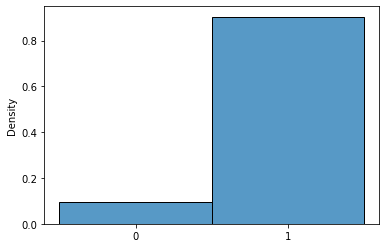

In [10]:
# Test Code
class DummyModule(nn.Module):
    def forward(self, state):
        return torch.FloatTensor([1,2]) # Constant output

# Sample 1000 actions
_actions = [epsilon_greedy(np.array([1,2,3,4]), DummyModule(), epsilon=0.2) for _ in range(1000)]

sns.histplot(_actions, discrete=True, stat="density")
plt.xticks([0,1])
plt.show()

_zeros = 1000 - sum(_actions)
# Note: This is a stochastic test. It produces a false error in 1% of the cases
assert 75 < _zeros < 125, f"Frequency of action 0 ({_zeros}) is outside the 99% confidence interval [76, 124]"

### c) Loss Function

In [11]:
mse = nn.MSELoss()

def compute_loss(q_network, target_network, states, actions, rewards, next_states, is_terminal, gamma=0.99):
    # Loss function
    qvals = []
    expected_qvals = []
    N, D = states.size()
    
    for i in range(N):
        state = states[i]
        action = actions[i]
        next_state = next_states[i]
        reward = rewards[i]
        
        qval = q_network.forward(state)[action]  # Q(s,a)
        best_action = np.argmax(q_network.forward(next_state).detach())   # Q(s', a)
        # next_action = np.argmax(q_next.detach())
        Q_hat = target_network.forward(next_state)[best_action]   # Expected Q value
        
        if is_terminal[i]:
            expected_qval = reward + 0*gamma*Q_hat   # Zero out target Q_values
        else:    
            expected_qval = reward + gamma*Q_hat  # Expected Q_value

        qvals.append(qval)
        expected_qvals.append(expected_qval)
        
    qvals = torch.stack(qvals)
    expected_qvals = torch.stack(expected_qvals)

    loss = mse(qvals, expected_qvals)

    return loss

### d) Training

  0%|          | 0/2000 [00:00<?, ?it/s]

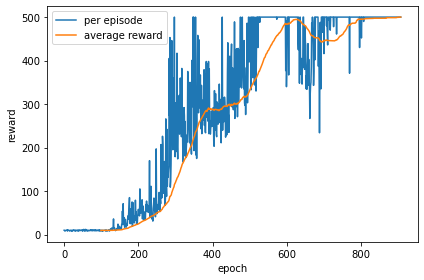

In [12]:
# Hyperparameters
epsilon = 0.05  # For epsilon greedy action sampling
batch_size = 64

NETWORK_UPDATE_FREQUENCY = 4
NETWORK_SYNC_FREQUENCY = 190
gamma = 0.99

episodes = 2000
# replay_buffer_size = 0


q_network = DeepQNetwork()
target_network = deepcopy(q_network)
optimizer = torch.optim.Adam(q_network.parameters(), lr=1e-3)
mse = nn.MSELoss()

step_count = 0
total_rewards = []
with tqdm(range(episodes)) as pbar:
    for _ in pbar:
        state, done = env.reset(), False
        rewards = []

        while not done:
            # Take a step
            action = epsilon_greedy(state, q_network, epsilon=epsilon)
            next_state, reward, done, _ = env.step(action)

            # Bookkeeping
            rewards.append(reward)
            buffer.add(state=state, action=action, reward=reward, next_state=next_state, is_terminal=done and env._elapsed_steps < 500)
            state = next_state

            step_count += 1
            
            # Update network every NETWORK_UPDATE_FREQUENCY steps
            if step_count % NETWORK_UPDATE_FREQUENCY == 0:
                # Sample batch of transitions
                state_batch, action_batch, reward_batch, next_state_batch, terminal_batch = buffer.sample_batch(batch_size=batch_size)
                state_batch = torch.FloatTensor(state_batch)
                next_state_batch = torch.FloatTensor(next_state_batch)
                action_batch = torch.LongTensor(action_batch).reshape(-1, 1)
                reward_batch = torch.FloatTensor(reward_batch).reshape(-1, 1)
                terminal_batch = torch.BoolTensor(terminal_batch)

                # Compute loss
                loss = compute_loss(q_network, target_network, state_batch, action_batch, reward_batch, next_state_batch, terminal_batch, gamma)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
           
            # Sync networks every NETWORK_SYNC_FREQUENCY steps
            if step_count % NETWORK_SYNC_FREQUENCY == 0:                          
                target_network.load_state_dict(q_network.state_dict().copy())
    
        total_rewards.append(sum(rewards))

         # Print statistics
        pbar.set_description(f"Mean training reward {np.mean(total_rewards[-100:]):.02f}")
        if np.mean(total_rewards[-100:]) == 500:
            break # Stop training

# Save model
with open("solution/b2d.pt", "wb") as f:
    torch.save(q_network, f)

# Plot training  
plt.plot(total_rewards, label="per episode")

plt.plot(pd.DataFrame(total_rewards).rolling(100).mean(), label="average reward")
plt.xlabel("epoch")
plt.ylabel("reward")
plt.legend()
plt.tight_layout()
plt.savefig("solution/b2d.png")

In [13]:
# Test code
policy = q_network
policy.eval() # Switch to evaluation mode

def _rollout(seed):
    env.seed(seed)
    state, done = env.reset(), False
    while not done:
        probs = policy(torch.tensor(state).float().reshape((1, -1)))[0]
        action = np.argmax(probs.detach().numpy())  # Greedy action
        state, reward, done, _ = env.step(action)
    return env._elapsed_steps
        
_avg_reward = np.mean([_rollout(seed=i) for i in tqdm(range(100), desc="Validating")])
assert _avg_reward >= 487.5, f"Average reward below 487.5, got {_avg_reward}"
f"ok (Average reward {_avg_reward:0.2f})"

Validating:   0%|          | 0/100 [00:00<?, ?it/s]

'ok (Average reward 500.00)'